In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV,LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox
from scipy.special import inv_boxcox

sns.set(rc={"figure.figsize":(10, 10)})
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_FD001 = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt',sep=" ",header=None)
test_FD001 = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt',sep=" ",header=None)
RUL_FD001 = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt',sep=" ",header=None)

In [3]:
train_FD001.head()

0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00  23.4236 NaN NaN  
2  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95  23.3442 NaN NaN  
3  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88  23.3739 NaN NaN  
4  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90  23.4044 NaN NaN  

[5 rows x 28 columns]

In [4]:
train_FD001.isnull().sum()

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26    20631
27    20631
dtype: int64

# **Data Cleaning**

In [5]:
train_FD001.drop([26,27],axis=1,inplace=True)
test_FD001.drop([26,27],axis=1,inplace=True)
RUL_FD001.drop([1],axis=1,inplace=True)

In [6]:
idxcols = ['unit number','time(cycles)']
settings = ['operational setting 1','operational setting 2','operational setting 3']
sensors = []
for i in range(1,22):
    sensors.append('sensor measurement '+ str(i))
    
cols = idxcols + settings + sensors

In [7]:
train_FD001.columns=cols
test_FD001.columns=cols
train_FD001.head()

unit number  time(cycles)  operational setting 1  operational setting 2  \
0            1             1                -0.0007                -0.0004   
1            1             2                 0.0019                -0.0003   
2            1             3                -0.0043                 0.0003   
3            1             4                 0.0007                 0.0000   
4            1             5                -0.0019                -0.0002   

   operational setting 3  sensor measurement 1  sensor measurement 2  \
0                  100.0                518.67                641.82   
1                  100.0                518.67                642.15   
2                  100.0                518.67                642.35   
3                  100.0                518.67                642.35   
4                  100.0                518.67                642.37   

   sensor measurement 3  sensor measurement 4  sensor measurement 5  ...  \
0               1589.70               1400.60                 14.62  ...   
1               1591.82               1403.14                 14.62  ...   
2               1587.99               1404.20                 14.62  ...   
3               1582.79               1401.87                 14.62  ...   
4               1582.85               1406.22                 14.62  ...   

   sensor measurement 12  sensor measurement 13  sensor measurement 14  \
0                 521.66                2388.02                8138.62   
1                 522.28                2388.07                8131.49   
2                 522.42                2388.03                8133.23   
3                 522.86                2388.08                8133.83   
4                 522.19                2388.04                8133.80   

   sensor measurement 15  sensor measurement 16  sensor measurement 17  \
0                 8.4195                   0.03                    392   
1                 8.4318                   0.03                    392   
2                 8.4178                   0.03                    390   
3                 8.3682                   0.03                    392   
4                 8.4294                   0.03                    393   

   sensor measurement 18  sensor measurement 19  sensor measurement 20  \
0                   2388                  100.0                  39.06   
1                   2388                  100.0                  39.00   
2                   2388                  100.0                  38.95   
3                   2388                  100.0                  38.88   
4                   2388                  100.0                  38.90   

   sensor measurement 21  
0                23.4190  
1                23.4236  
2                23.3442  
3                23.3739  
4                23.4044  

[5 rows x 26 columns]

In [8]:
train_FD001.describe()

unit number  time(cycles)  operational setting 1  \
count  20631.000000  20631.000000           20631.000000   
mean      51.506568    108.807862              -0.000009   
std       29.227633     68.880990               0.002187   
min        1.000000      1.000000              -0.008700   
25%       26.000000     52.000000              -0.001500   
50%       52.000000    104.000000               0.000000   
75%       77.000000    156.000000               0.001500   
max      100.000000    362.000000               0.008700   

       operational setting 2  operational setting 3  sensor measurement 1  \
count           20631.000000                20631.0              20631.00   
mean                0.000002                  100.0                518.67   
std                 0.000293                    0.0                  0.00   
min                -0.000600                  100.0                518.67   
25%                -0.000200                  100.0                518.67   
50%                 0.000000                  100.0                518.67   
75%                 0.000300                  100.0                518.67   
max                 0.000600                  100.0                518.67   

       sensor measurement 2  sensor measurement 3  sensor measurement 4  \
count          20631.000000          20631.000000          20631.000000   
mean             642.680934           1590.523119           1408.933782   
std                0.500053              6.131150              9.000605   
min              641.210000           1571.040000           1382.250000   
25%              642.325000           1586.260000           1402.360000   
50%              642.640000           1590.100000           1408.040000   
75%              643.000000           1594.380000           1414.555000   
max              644.530000           1616.910000           1441.490000   

       sensor measurement 5  ...  sensor measurement 12  \
count          2.063100e+04  ...           20631.000000   
mean           1.462000e+01  ...             521.413470   
std            1.776400e-15  ...               0.737553   
min            1.462000e+01  ...             518.690000   
25%            1.462000e+01  ...             520.960000   
50%            1.462000e+01  ...             521.480000   
75%            1.462000e+01  ...             521.950000   
max            1.462000e+01  ...             523.380000   

       sensor measurement 13  sensor measurement 14  sensor measurement 15  \
count           20631.000000           20631.000000           20631.000000   
mean             2388.096152            8143.752722               8.442146   
std                 0.071919              19.076176               0.037505   
min              2387.880000            8099.940000               8.324900   
25%              2388.040000            8133.245000               8.414900   
50%              2388.090000            8140.540000               8.438900   
75%              2388.140000            8148.310000               8.465600   
max              2388.560000            8293.720000               8.584800   

       sensor measurement 16  sensor measurement 17  sensor measurement 18  \
count           2.063100e+04           20631.000000                20631.0   
mean            3.000000e-02             393.210654                 2388.0   
std             1.387812e-17               1.548763                    0.0   
min             3.000000e-02             388.000000                 2388.0   
25%             3.000000e-02             392.000000                 2388.0   
50%             3.000000e-02             393.000000                 2388.0   
75%             3.000000e-02             394.000000                 2388.0   
max             3.000000e-02             400.000000                 2388.0   

       sensor measurement 19  sensor measurement 20  sensor measurement 21  
count                20631.0           20631.000000           20631.000000  
mean 

<AxesSubplot:>

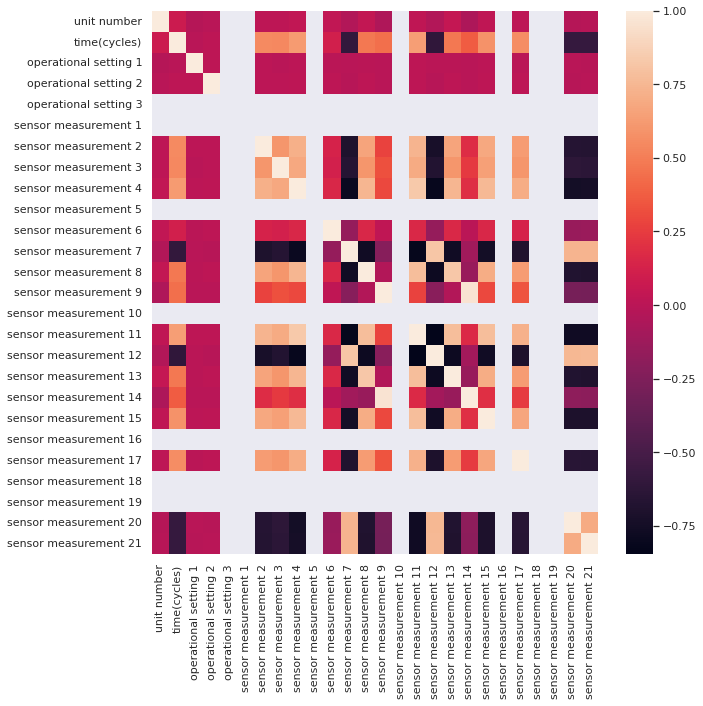

In [9]:
sns.heatmap(train_FD001.corr())

sensor measurement 1,sensor measurement 5,sensor measurement 6,sensor measurement 10,sensor measurement 16,sensor measurement 18,sensor measurement 19 have constant values. So we'll drop them

In [10]:
train_FD001.drop(columns=['sensor measurement 1','sensor measurement 5','sensor measurement 6','sensor measurement 10','sensor measurement 16','sensor measurement 18','sensor measurement 19'],inplace=True)
test_FD001.drop(columns=['sensor measurement 1','sensor measurement 5','sensor measurement 6','sensor measurement 10','sensor measurement 16','sensor measurement 18','sensor measurement 19'],inplace=True)

In [11]:
rul_list = []

for n in np.arange(1,101):
    
    time_list = np.array(train_FD001[train_FD001['unit number'] == n]['time(cycles)'])
    length = len(time_list)
    rul = list(length - time_list)
    rul_list += rul
    
train_FD001['rul'] = rul_list

# **Data Exploration**

<AxesSubplot:>

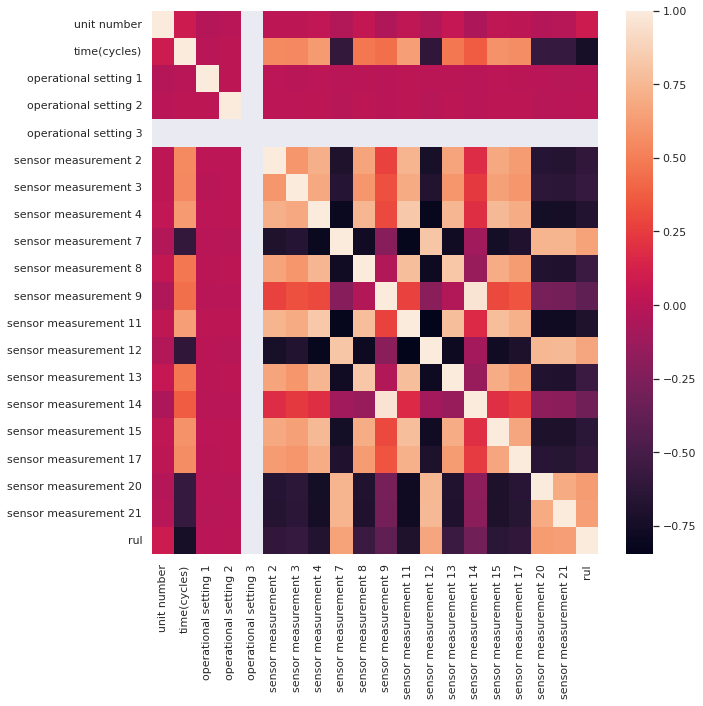

In [12]:
sns.heatmap(train_FD001.corr())

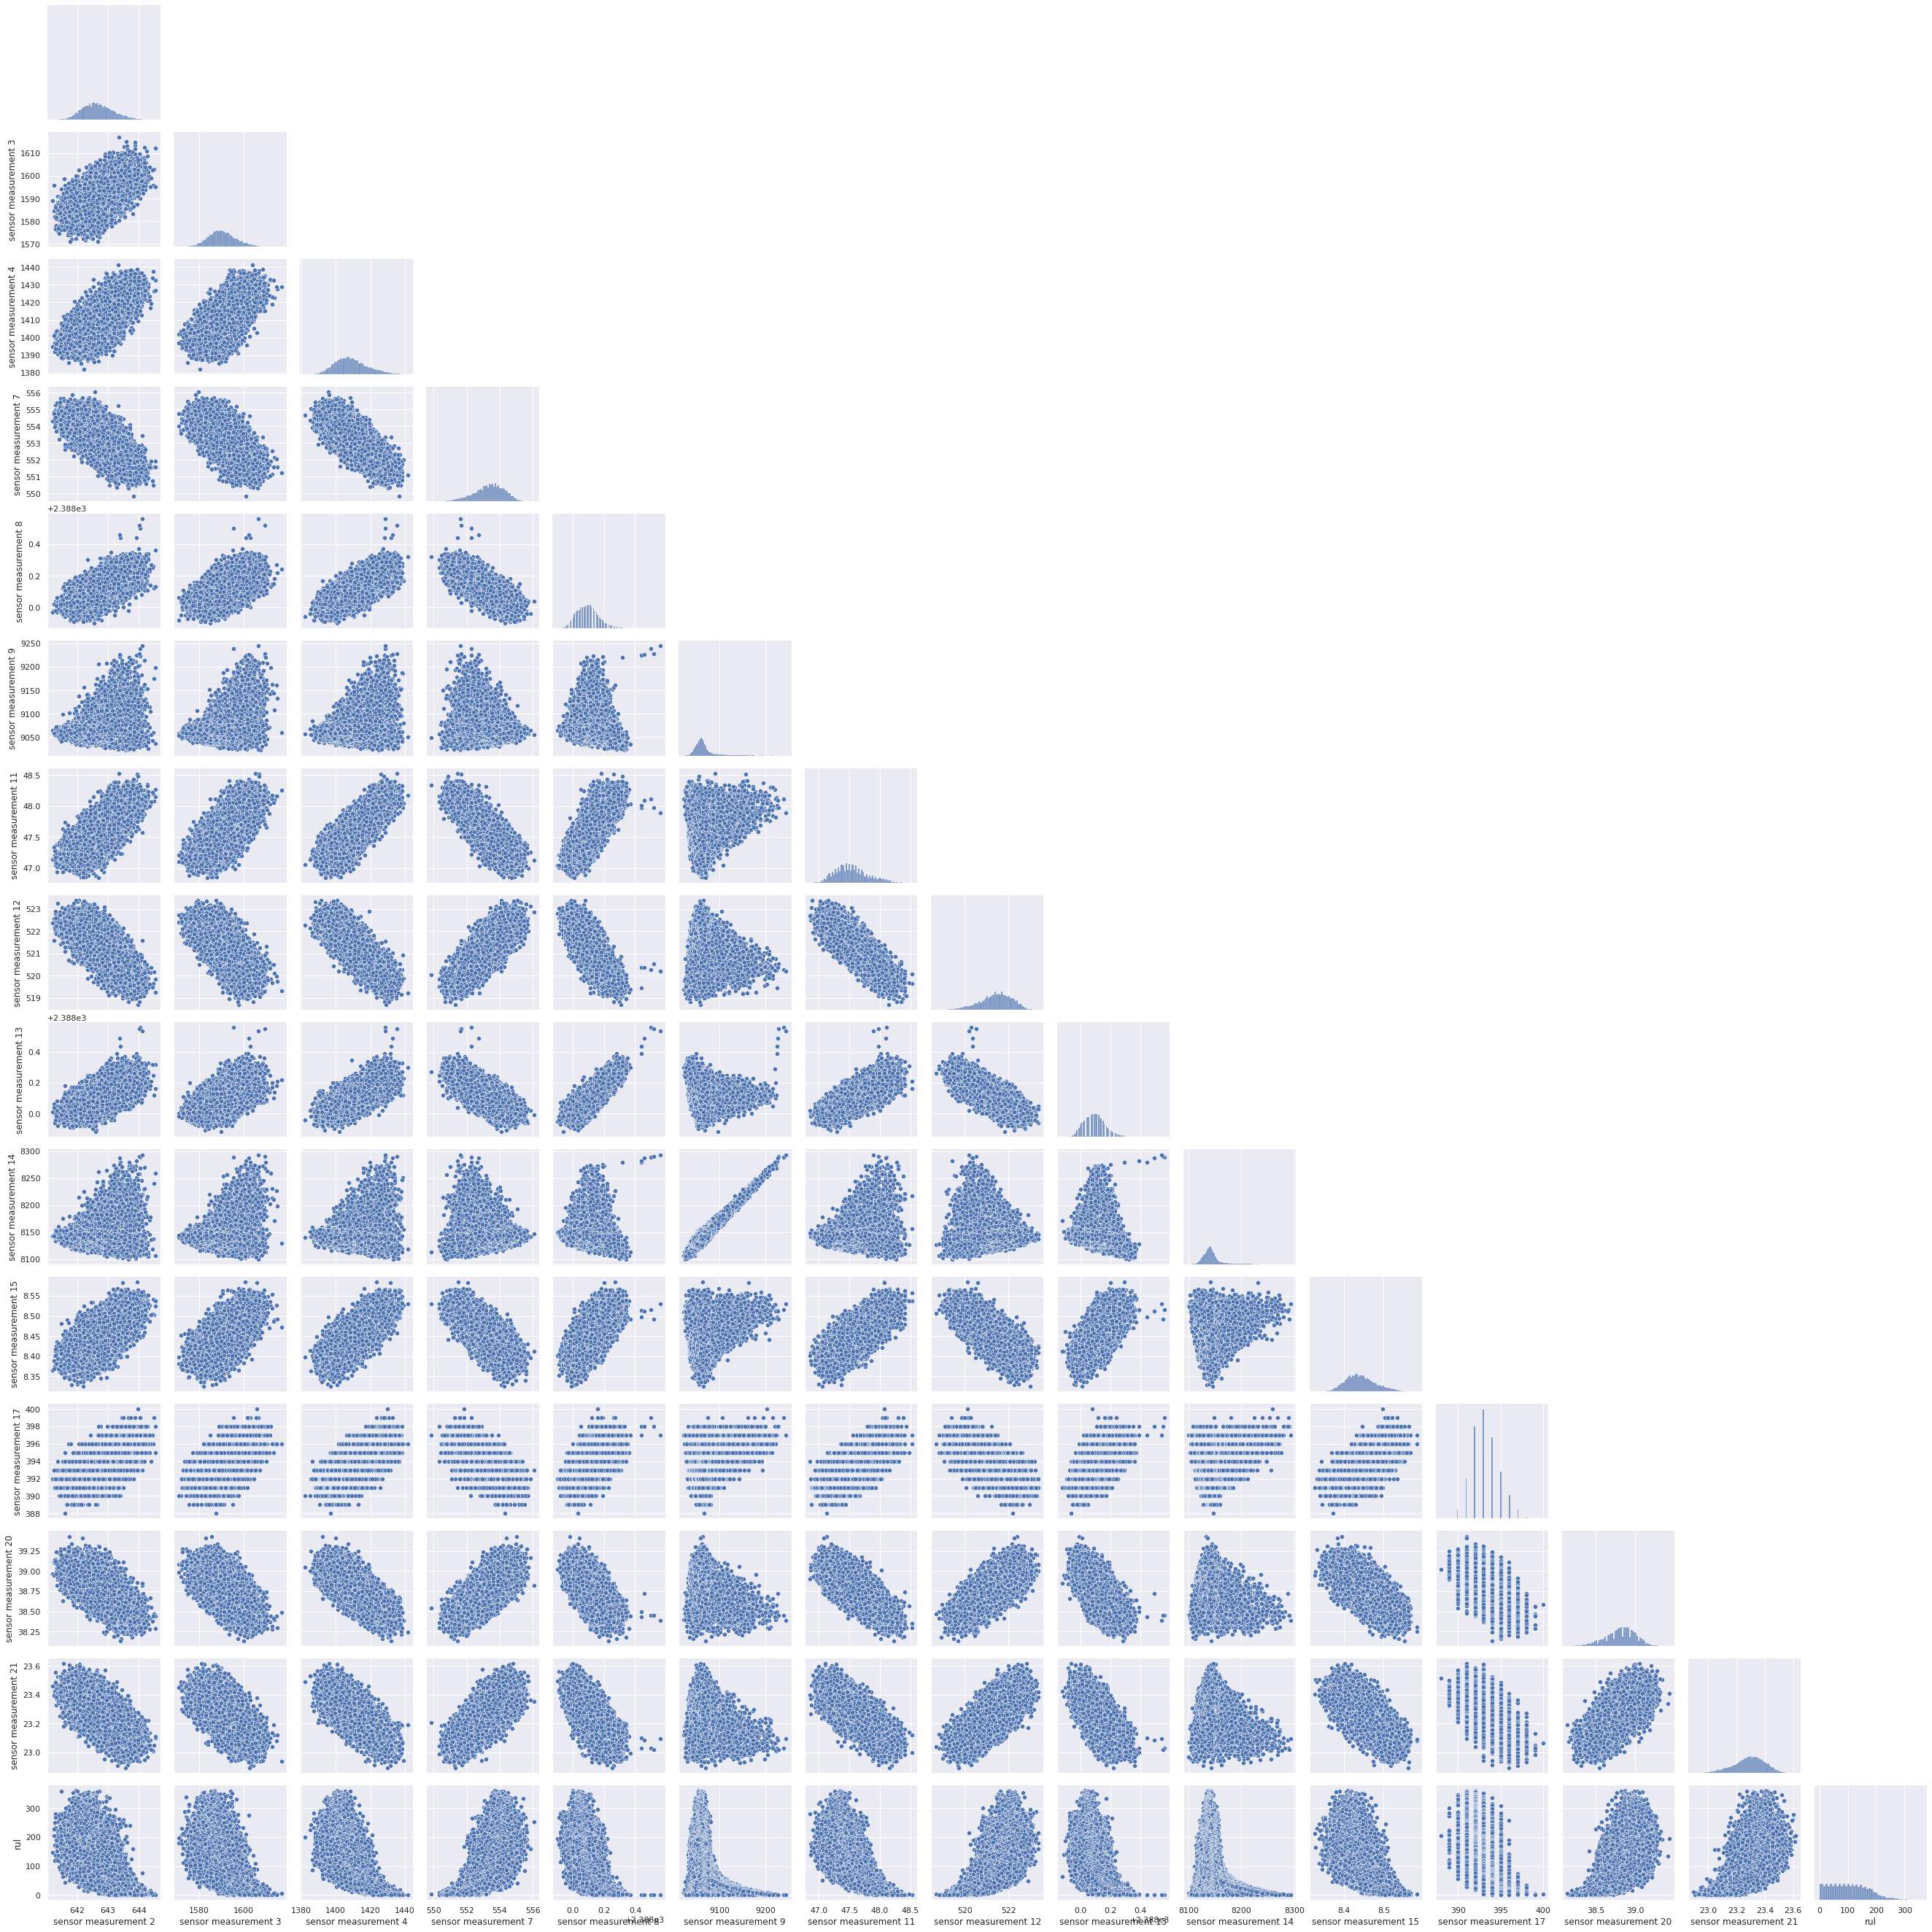

In [15]:
sns.pairplot(train_FD001.iloc[:,5:],corner=True)

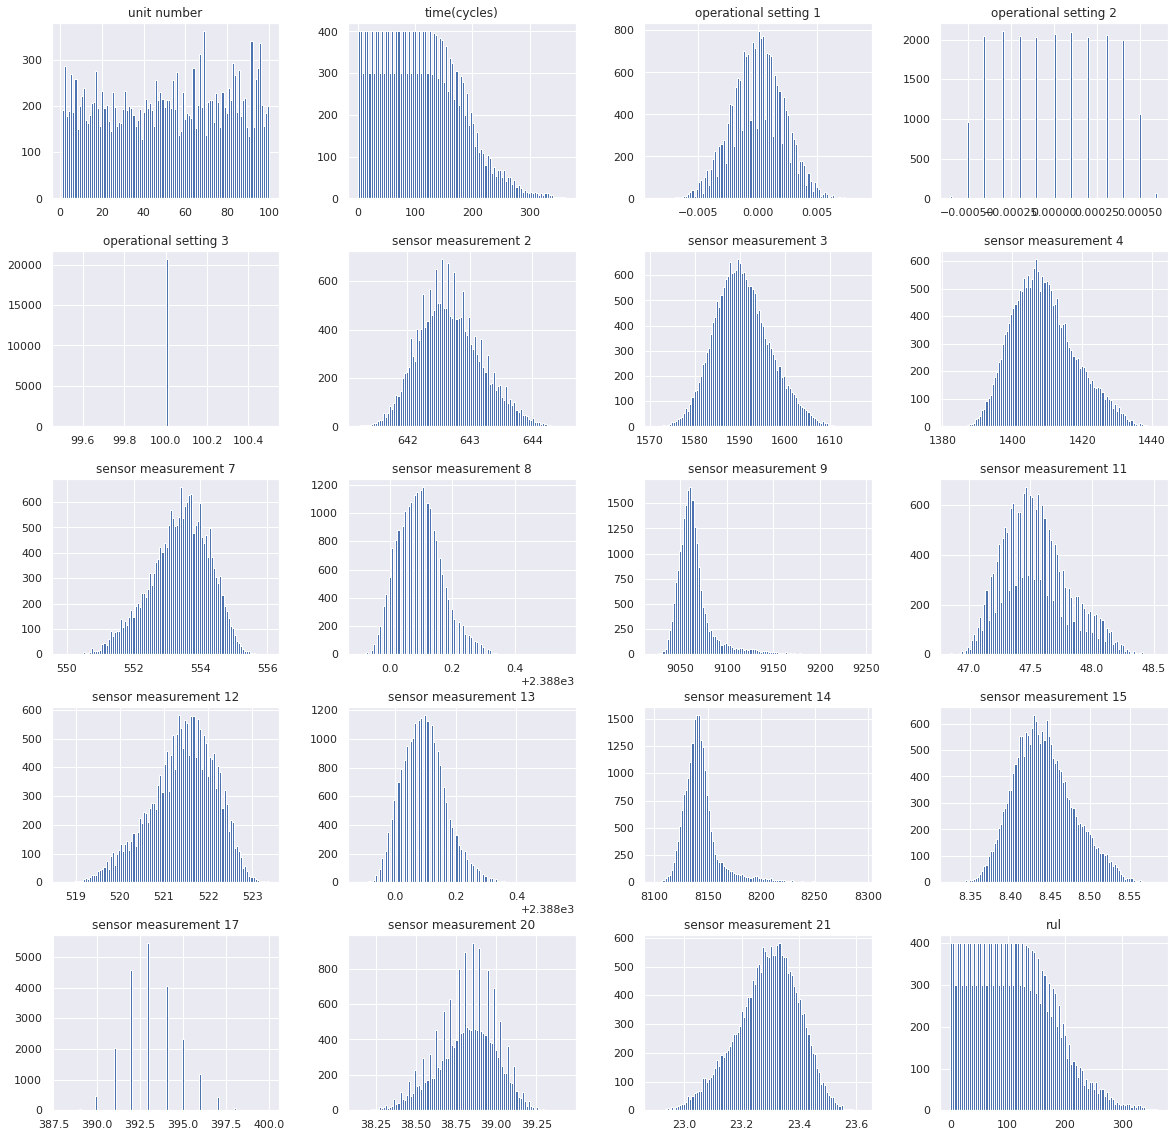

In [16]:
train_FD001.hist(bins=100,figsize=(20,20))
plt.show()

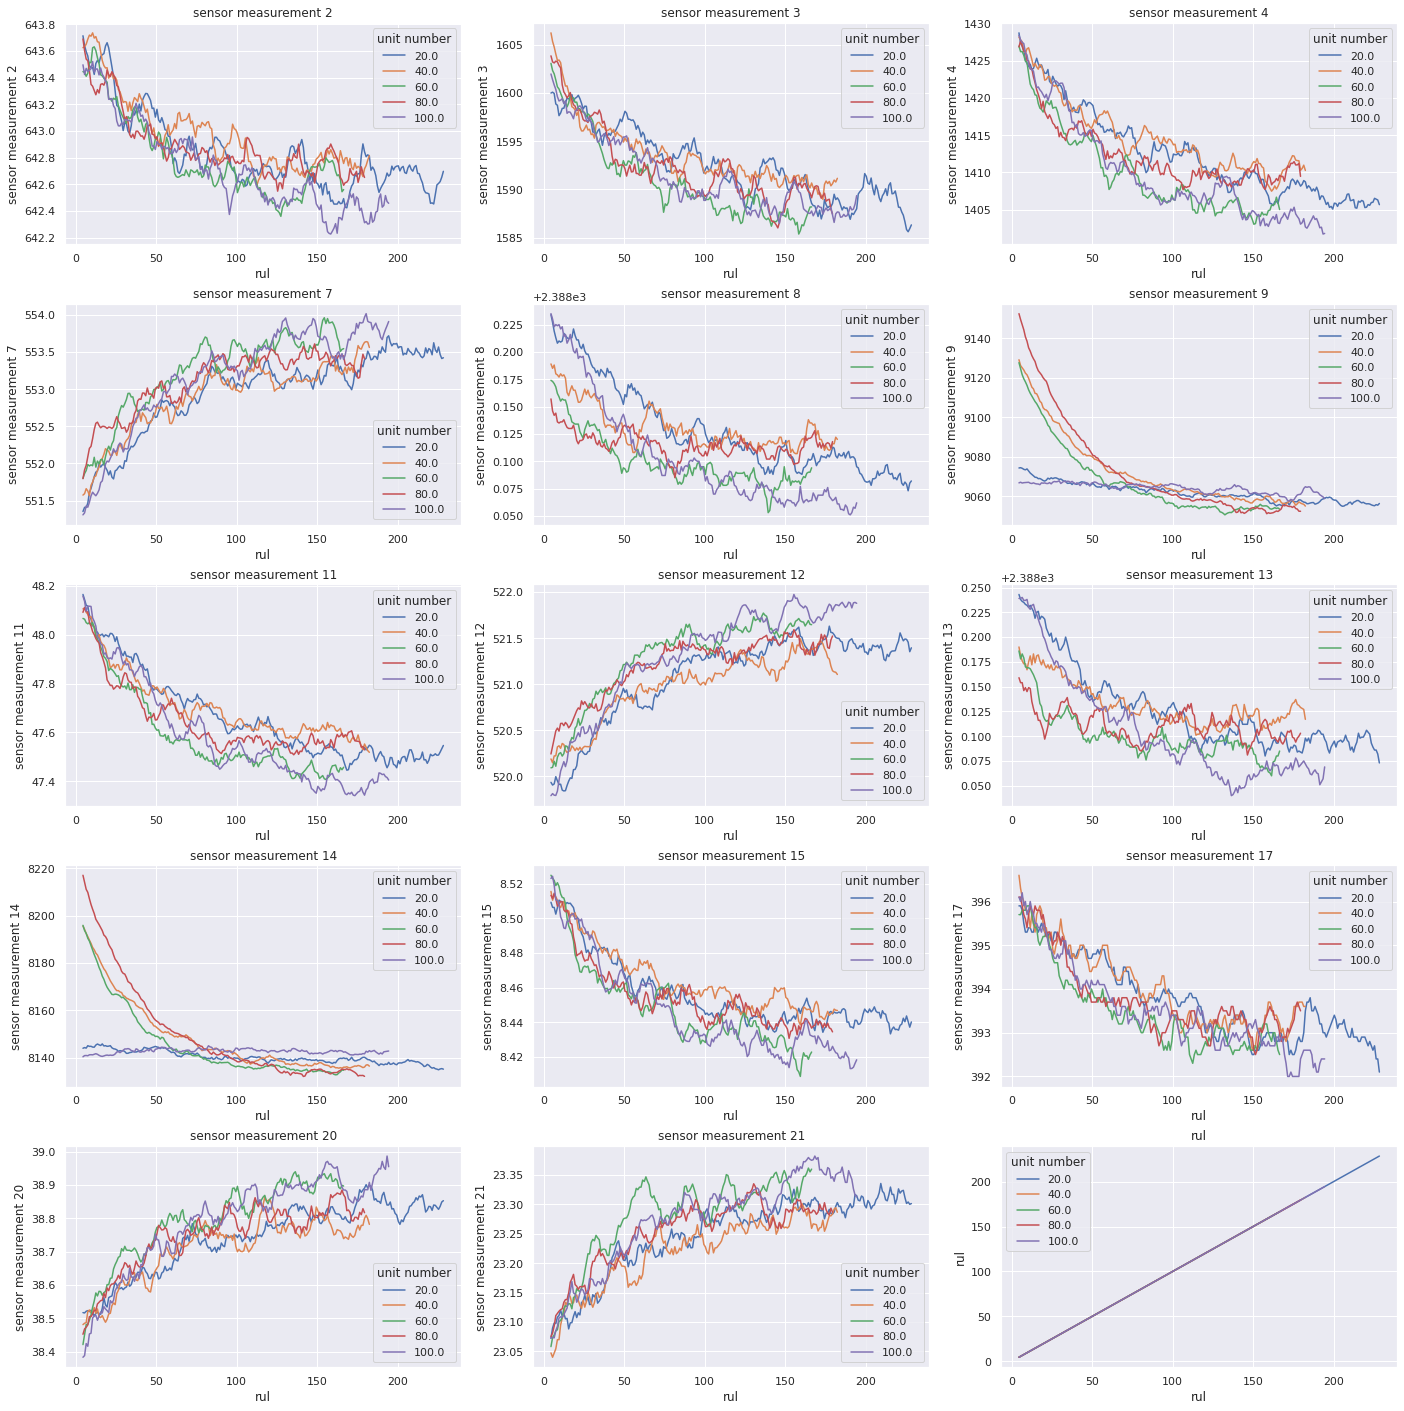

In [14]:
fig, axes = plt.subplots(5,3,figsize=(20,20))
fig.tight_layout(pad=3)

for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=train_FD001.rolling(10).mean()[train_FD001.rolling(10).mean()['unit number']%20 == 0],y=train_FD001.columns[i+5],x='rul',ax=ax,hue='unit number',palette=sns.color_palette()[:5]).set(title=train_FD001.columns[i+5])

<AxesSubplot:title={'center':'Remaining Useful Life for different Units'}, xlabel='unit number', ylabel='RUL'>

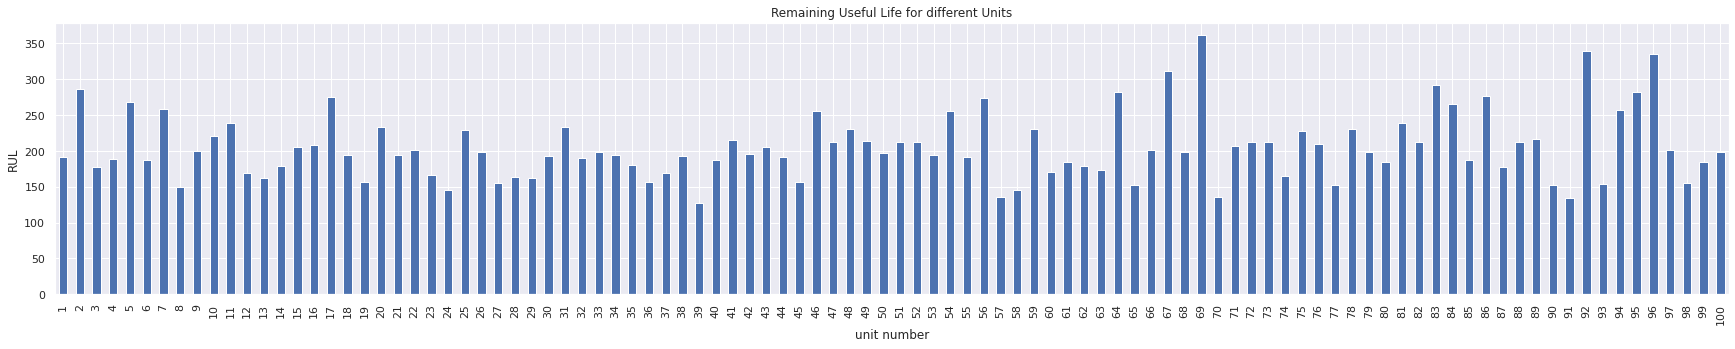

In [15]:
train_FD001.groupby(['unit number']).max()['rul'].plot(kind='bar',figsize=(30,5),ylabel='RUL',title='Remaining Useful Life for different Units')

# **ML Modeling**

In [159]:
y_test = RUL_FD001[0]
X_test = test_FD001.groupby(['unit number']).last().reset_index().iloc[:,5:]

In [70]:
X_train, X_valid, y_train, y_valid=train_test_split(train_FD001.iloc[:,5:-1],train_FD001['rul'], test_size=0.3, random_state=42)

In [160]:
sc = StandardScaler()
X_train_s = sc.fit_transform(X_train)
X_valid_s = sc.transform(X_valid)
X_test_s = sc.transform(X_test)

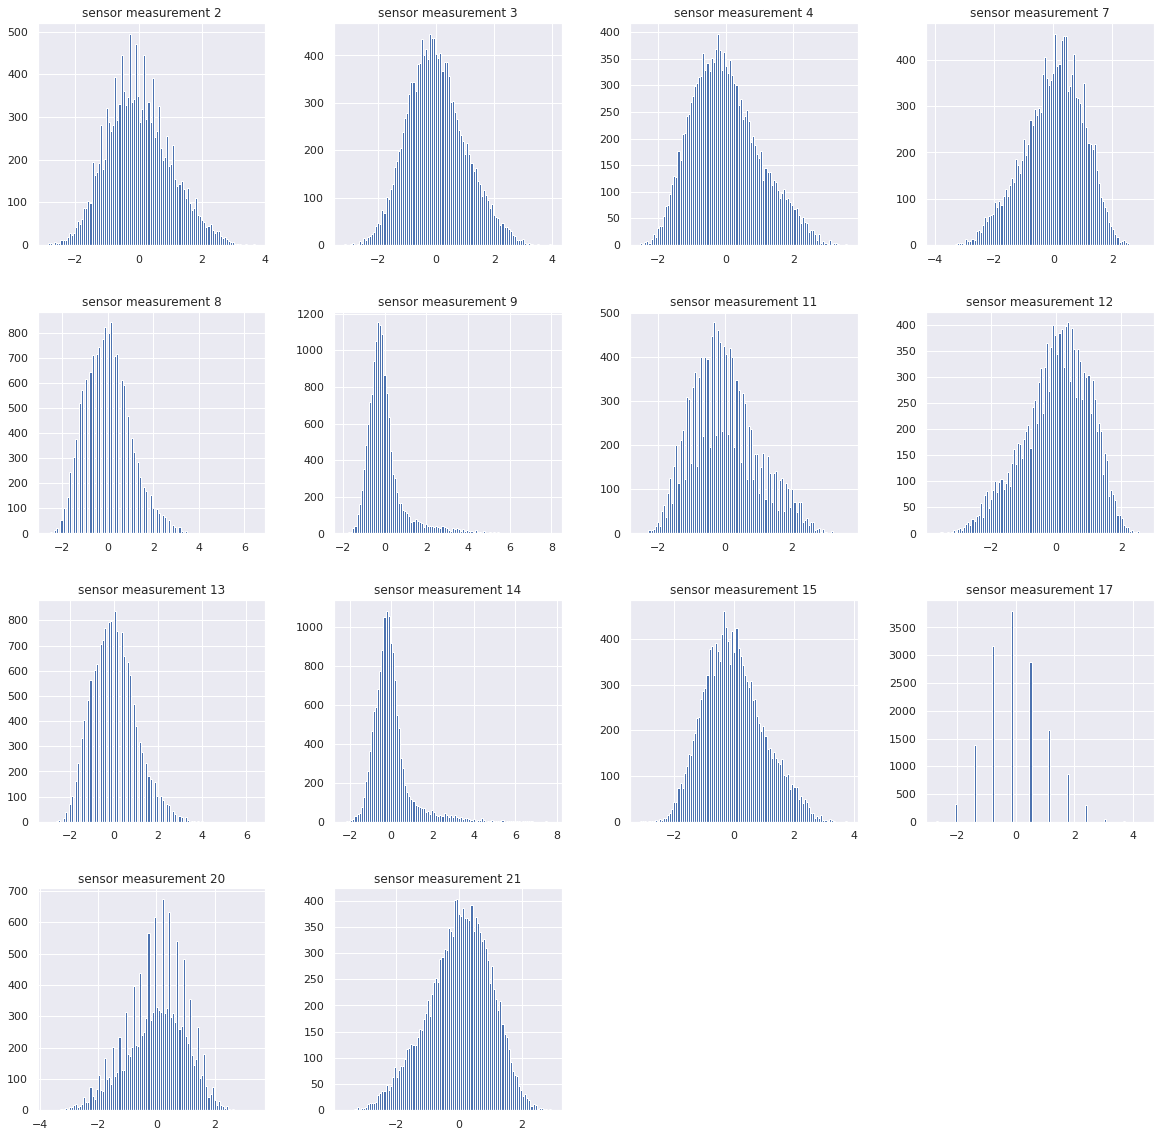

In [16]:
pd.DataFrame(X_train_s,columns=train_FD001.iloc[:,5:-1].columns).hist(bins=100,figsize=(20,20))
plt.show()

In [34]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [72]:
lr = LinearRegression()
lr.fit(X_train_s,y_train)

y_pred = lr.predict(X_test_s)
evaluate(y_test,y_pred)

test set RMSE:32.21708145030698, R2:0.39894689374593517


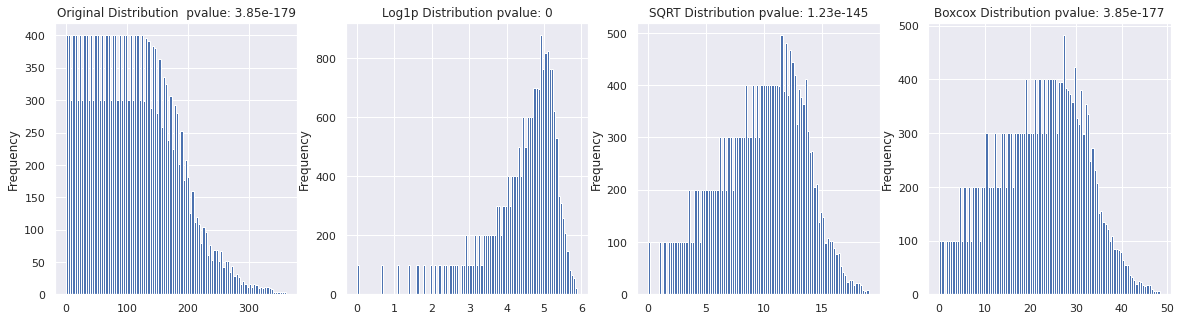

In [73]:
bcx, lm = boxcox(train_FD001['rul']+1)
bcx = pd.Series(bcx)

fig, ax = plt.subplots(1,4,figsize=(20,5))

train_FD001['rul'].plot(kind='hist',bins=100,ax=ax[0],title='Original Distribution  pvalue: '+ str(format(normaltest(train_FD001['rul'])[1],'.3g')))
np.log1p(train_FD001['rul']).plot(kind='hist',bins=100,ax=ax[1],title='Log1p Distribution pvalue: '+ str(format(normaltest(np.log1p(train_FD001['rul']))[1],'.3g')))
np.sqrt(train_FD001['rul']).plot(kind='hist',bins=100,ax=ax[2],title='SQRT Distribution pvalue: '+ str(format(normaltest(np.sqrt(train_FD001['rul']))[1],'.3g')))
bcx.plot(kind='hist',bins=100,ax=ax[3],title='Boxcox Distribution pvalue: '+ str(format(normaltest(bcx)[1],'.3g')))
plt.show()

In [74]:
bcx, lm = boxcox(y_train+1)
bcx = pd.Series(bcx)

lr = LinearRegression()
lr.fit(X_train_s,bcx)

y_pred = lr.predict(X_test_s)
y_pred = inv_boxcox(y_pred,lm)-1
evaluate(y_test,y_pred)

test set RMSE:29.41216996001064, R2:0.4990497593121377


In [75]:
pf = PolynomialFeatures(degree=2,include_bias=True)
X_train_pf = pf.fit_transform(X_train_s)
X_valid_pf = pf.transform(X_valid_s)


lr = LinearRegression()
lr.fit(X_train_pf,bcx)

y_pred = lr.predict(X_valid_pf)
y_pred = inv_boxcox(y_pred,lm)-1
y_pred[np.isnan(y_pred)] = 0
evaluate(y_valid,y_pred,'validation')

validation set RMSE:42.18498745209934, R2:0.6114786986897751


In [76]:
X_test_pf = pf.transform(X_test_s)
y_pred = lr.predict(X_test_pf)
y_pred = inv_boxcox(y_pred,lm)-1
evaluate(y_test,y_pred,'test')

test set RMSE:29.013763401914805, R2:0.5125292223904508


In [55]:
estimator = Pipeline([('polynomial_features',PolynomialFeatures()),('scaler',StandardScaler()),('ridge_regression',Ridge())])
params = {
    'polynomial_features__degree': [2,3,4],
    'ridge_regression__alpha': np.geomspace(4,20,30)
}

grid = GridSearchCV(estimator,params,cv=kf)
grid.fit(train_FD001.iloc[:,5:-1],train_FD001.loc[:,'rul'])

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [2, 3, 4],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [58]:
y_pred = grid.predict(train_FD001.iloc[:,5:-1])
r2_score(train_FD001['rul'],y_pred)

0.6245139494751215

In [91]:
alphas = [0.005, 0.05, 0.1, 1, 5, 20, 50, 80, 100, 120, 140]

ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(X_train_pf,y_train)

evaluate(y_valid, ridgeCV.predict(X_valid_pf),'validation')
evaluate(y_test, ridgeCV.predict(X_test_pf),'test')

validation set RMSE:42.21839977551966, R2:0.6108630038147692
test set RMSE:31.572624757944507, R2:0.42275280420364647


In [90]:
lassoCV = LassoCV(alphas=alphas,max_iter=1e6,cv=4).fit(X_train_pf,y_train)
evaluate(y_valid, lassoCV.predict(X_valid_pf),'validation')
evaluate(y_test, lassoCV.predict(X_test_pf),'test')

validation set RMSE:42.161230494738575, R2:0.6119161758840428
test set RMSE:31.463947777781463, R2:0.4267198810130427


In [93]:
l1_ratios = np.linspace(0.1,0.9,9)
elasticNetCV = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios,max_iter=1e6).fit(X_train_pf,y_train)

evaluate(y_valid,elasticNetCV.predict(X_valid_pf),'validation')
evaluate(y_test, elasticNetCV.predict(X_test_pf),'test')

validation set RMSE:42.15649104336437, R2:0.6120034219635088
test set RMSE:31.393483193694802, R2:0.4292847664740881


In [95]:
regressor = SVR(kernel='rbf')
regressor.fit(X_train_pf, y_train) # fitting

y_svr_train = regressor.predict(X_train_pf) 
evaluate(y_train,y_svr_train, label='train')

y_svr_valid= regressor.predict(X_valid_pf)  
evaluate(y_valid, y_svr_valid, label='valid')

y_svr_test = regressor.predict(X_test_pf)
evaluate(y_test, y_svr_test, label='test')

train set RMSE:44.783094509217676, R2:0.5833974875895316
valid set RMSE:44.49338552210573, R2:0.5677948957458696
test set RMSE:22.819240334108862, R2:0.6984614649387418


In [96]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

rf.fit(X_train_pf, y_train)

y_rf_train = rf.predict(X_train_pf)
evaluate(y_train,y_rf_train, label='train')

y_rf_valid = rf.predict(X_valid_pf)
evaluate(y_valid, y_rf_valid, label='valid')

y_rf_test = rf.predict(X_test_pf)
evaluate(y_test, y_rf_test, label='test')

train set RMSE:15.436116626149452, R2:0.9505040360056995
valid set RMSE:41.39513811680314, R2:0.6258914290736189
test set RMSE:32.32114017172043, R2:0.3950579117265137


In [103]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02, gamma=0, subsample=0.8,colsample_bytree=0.5, max_depth=3)

xgb.fit(X_train_pf, y_train)

y_xgb_train = xgb.predict(X_train_pf)
evaluate(y_train,y_xgb_train, label='train')

y_xgb_valid = xgb.predict(X_valid_pf)
evaluate(y_valid, y_xgb_valid, label='valid')

y_xgb_test = xgb.predict(X_test_pf)
evaluate(y_test, y_xgb_test, label='test')

train set RMSE:44.052612097511876, R2:0.596877522267353
valid set RMSE:44.114097358995515, R2:0.5751322362700653
test set RMSE:22.42778128831522, R2:0.7087183806371353


In [149]:
df = train_FD001.groupby(['unit number']).rolling(10,min_periods=1).mean().reset_index('unit number')
X_train, X_valid, y_train, y_valid=train_test_split(df.iloc[:,5:-1],train_FD001['rul'].clip(upper=195), test_size=0.3, random_state=42)

In [180]:
train_FD001.groupby(['unit number']).rolling(10,min_periods=1).mean().reset_index('unit number')

unit number  time(cycles)  operational setting 1  \
0                1           1.0              -0.000700   
1                1           1.5               0.000600   
2                1           2.0              -0.001033   
3                1           2.5              -0.000600   
4                1           3.0              -0.000860   
...            ...           ...                    ...   
20626          100         191.5              -0.000110   
20627          100         192.5              -0.000420   
20628          100         193.5              -0.000300   
20629          100         194.5              -0.000560   
20630          100         195.5              -0.000870   

       operational setting 2  operational setting 3  sensor measurement 2  \
0              -4.000000e-04                  100.0            641.820000   
1              -3.500000e-04                  100.0            641.985000   
2              -1.333333e-04                  100.0            642.106667   
3              -1.000000e-04                  100.0            642.167500   
4              -1.200000e-04                  100.0            642.208000   
...                      ...                    ...                   ...   
20626           5.000000e-05                  100.0            643.456000   
20627          -2.000000e-05                  100.0            643.447000   
20628           1.301043e-19                  100.0            643.470000   
20629           2.000000e-05                  100.0            643.424000   
20630          -5.000000e-05                  100.0            643.497000   

       sensor measurement 3  sensor measurement 4  sensor measurement 7  \
0               1589.700000           1400.600000            554.360000   
1               1590.760000           1401.870000            554.055000   
2               1589.836667           1402.646667            554.123333   
3               1588.075000           1402.452500            554.205000   
4               1587.030000           1403.206000            554.164000   
...                     ...                   ...                   ...   
20626           1599.625000           1426.079000            551.477000   
20627           1600.379000           1427.288000            551.410000   
20628           1600.848000           1427.449000            551.427000   
20629           1601.389000           1427.787000            551.334000   
20630           1601.982000           1428.397000            551.307000   

       sensor measurement 8  sensor measurement 9  sensor measurement 11  \
0                 2388.0600           9046.190000                 47.470   
1                 2388.0500           9045.130000                 47.480   
2                 2388.0600           9047.733333                 47.410   
3                 2388.0725           9048.170000                 47.340   
4                 2388.0700           9049.566000                 47.328   
...                     ...                   ...                    ...   
20626             2388.2240           9066.903000                 48.116   
20627             2388.2250           9066.820000                 48.116   
20628             2388.2230           9066.642000                 48.096   
20629             2388.2300           9067.045000                 48.136   
20630             2388.2350           9066.719000                 48.157   

       sensor measurement 12  sensor measurement 13  sensor measurement 14  \
0                    521.660               2388.020            8138.620000   
1                    521.970               2388.045            8135.055000   
2                    522.120               2388.040            8134.446667   
3                    522.305               2388.050            8134.292500   
4                    522.282               2388.048            8134.194000   
...                      ...                    ...                    ...   
20626        

In [163]:
sc = StandardScaler()
X_train_s = sc.fit_transform(X_train)
X_valid_s = sc.transform(X_valid)
X_test_s = sc.transform(X_test)

# pf = PolynomialFeatures(degree=2,include_bias=True)
# X_train_pf = pf.fit_transform(X_train_s)
# X_valid_pf = pf.transform(X_valid_s)
# X_test_pf = pf.transform(X_test_s)

lr = LinearRegression()
lr.fit(X_train_s,y_train)

y_pred = lr.predict(X_train_s)
evaluate(y_train,y_pred,'train')

y_pred = lr.predict(X_valid_s)
evaluate(y_valid,y_pred,'validation')

y_pred = lr.predict(X_test_s)
evaluate(y_test,y_pred,'test')

train set RMSE:35.617862331859044, R2:0.6562530290227397
validation set RMSE:36.14979563001944, R2:0.6356044439062649
test set RMSE:32.795709276900546, R2:0.3771628460105033


In [152]:
regressor = SVR(kernel='rbf')
regressor.fit(X_train_s, y_train)

y_svr_train = regressor.predict(X_train_s) 
evaluate(y_train,y_svr_train, label='train')

y_svr_valid= regressor.predict(X_valid_s)  
evaluate(y_valid, y_svr_valid, label='valid')

y_svr_test = regressor.predict(X_test_s)
evaluate(y_test, y_svr_test, label='test')

train set RMSE:32.07085501395251, R2:0.7213081587267586
valid set RMSE:32.64925155293979, R2:0.7027595985095741
test set RMSE:21.179556681418834, R2:0.7402388569342855


In [153]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

rf.fit(X_train_s, y_train)

y_rf_train = rf.predict(X_train_s)
evaluate(y_train,y_rf_train, label='train')

y_rf_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_rf_valid, label='valid')

y_rf_test = rf.predict(X_test_s)
evaluate(y_test, y_rf_test, label='test')

train set RMSE:8.123092319712256, R2:0.9821208875391337
valid set RMSE:22.11804883129144, R2:0.8635872373831845
test set RMSE:28.715314415830445, R2:0.5225063421117611


In [154]:
estimator = RandomForestRegressor()
params = { 
    'n_estimators': [50,90,120],
    'max_depth' : [8,9,10],
}
grid =GridSearchCV(estimator,params,n_jobs=-1,cv=3)
grid.fit(X_train_s, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('polynomial_features',
                                        PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('ridge_regression', Ridge())]),
             param_grid={'polynomial_features__degree': [2, 3, 4],
                         'ridge_regression__alpha': array([ 4.        ,  4.22826702,  4.46956049,  4.7246238 ,  4.99424274,
        5.27924796,  5.58051751,  5.89897953,  6.23561514,  6.59146146,
        6.96761476,  7.36523392,  7.78554391,  8.22983963,  8.69948987,
        9.19594151,  9.72072404, 10.27545421, 10.86184103, 11.48169104,
       12.13691388, 12.82952815, 13.56166768, 14.33558803, 15.15367351,
       16.01844446, 16.93256509, 17.89885162, 18.92028098, 20.        ])})

In [179]:
print(grid.best_score_ , grid.best_params_,'\n')
evaluate(y_train,grid.predict(X_train_s),'train')
evaluate(y_valid,grid.predict(X_valid_s),'validation')
evaluate(y_test,grid.predict(X_test_s),'test')

0.7256738225462692 {'polynomial_features__degree': 4, 'ridge_regression__alpha': 15.153673507519274} 

train set RMSE:31.03677047859472, R2:0.7389905526298333
validation set RMSE:32.16098964437105, R2:0.7115834433201846
test set RMSE:66.53407075412191, R2:-1.5634724075949347


In [164]:
xgb = xgboost.XGBRegressor(n_estimators=50,max_depth=6,learning_rate=0.1,reg_lambda=0.02,gamma=0.4,random_state=42)
xgb.fit(X_train_s, y_train)
evaluate(y_train,xgb.predict(X_train_s),'train')
evaluate(y_valid,xgb.predict(X_valid_s),'validation')
evaluate(y_test,xgb.predict(X_test_s),'test')

train set RMSE:24.700584556401164, R2:0.8346829524285111
validation set RMSE:27.945652965422145, R2:0.7822340860035218
test set RMSE:36.3860946522397, R2:0.23332492271463556


<BarContainer object of 14 artists>

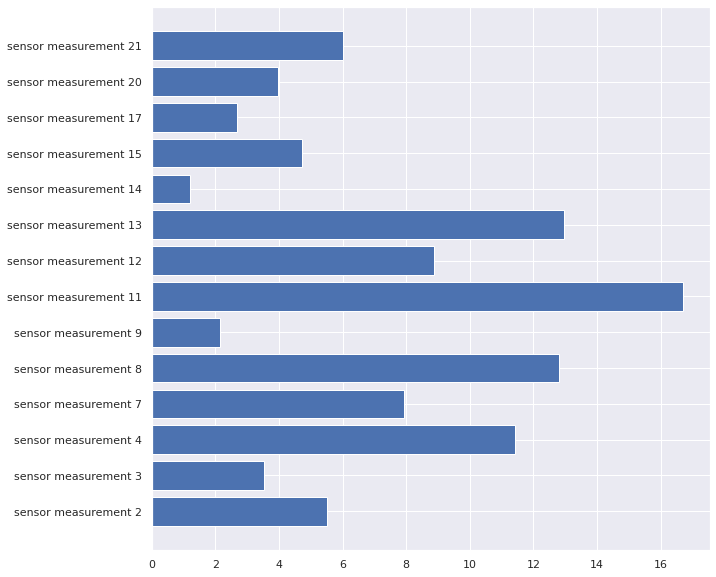

In [175]:
plt.barh(train_FD001.columns[5:-1],abs(lr.coef_))

<BarContainer object of 14 artists>

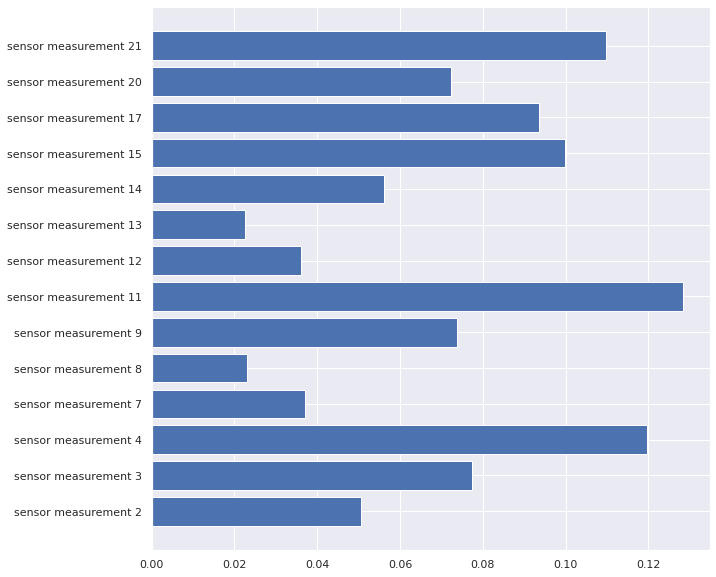

In [177]:
plt.barh(train_FD001.columns[5:-1],abs(rf.feature_importances_))